This notebook builds and evaluates a binary image classification model using a pretrained ResNet-18 on chest X-ray images to detect pneumonia.

#**Downloading Dataset from Kaggle**

In [ ]:
from google.colab import files
files.upload()

In [ ]:
import os
import zipfile

# Make Kaggle folder and move file
os.makedirs('/root/.kaggle', exist_ok=True)
!mv kaggle.json /root/.kaggle/kaggle.json

# Set permissions
!chmod 600 /root/.kaggle/kaggle.json


In [ ]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
100% 2.29G/2.29G [00:14<00:00, 250MB/s]
100% 2.29G/2.29G [00:14<00:00, 170MB/s]


In [ ]:
!unzip chest-xray-pneumonia.zip

Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0446-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0447-0001.jpeg  
  inflating:

#**Installing Required Libraries**

In [ ]:
!pip install torchmetrics


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 962.5/962.5 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 86.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 70.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 41.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 67.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [ ]:
!pip install mlflow


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.0/29.0 MB 44.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 55.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 733.7/733.7 kB 34.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.4/203.4 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.8/65.8 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.4/118.4 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.2/196.2 kB 8.6 MB/s eta 0:00:00


In [ ]:
!pip install pyngrok

#**Importing Required Libraries**

In [ ]:
# Data loading and preprocessing
import os
import random
import shutil

# Torch libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import models
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms

# Evaluation metrics and plotting
import numpy as np
from torchmetrics import Accuracy, F1Score
import matplotlib.pyplot as plt


#**Setting the Random Seed**
Set a fixed seed to ensure consistent and reproducible results across runs.

In [ ]:
seed_value = 12345
torch.manual_seed(seed_value)
np.random.seed(seed_value)
random.seed(seed_value)


#**Split Validation Data**
Moves a fixed number of images from each class in the training set to a validation folder to create a separate validation datase

In [ ]:

def transfer_images(source_path, target_path, count=50):
    os.makedirs(target_path, exist_ok=True)
    image_files = os.listdir(source_path)
    selected_files = random.sample(image_files, count)

    for image in selected_files:
        src = os.path.join(source_path, image)
        dst = os.path.join(target_path, image)
        shutil.move(src, dst)

transfer_images('/content/chest_xray/train/NORMAL', '/content/chest_xray/val/NORMAL', count=50)
transfer_images('/content/chest_xray/train/PNEUMONIA', '/content/chest_xray/val/PNEUMONIA', count=50)


#**Image Normalization**
Defines a transformation pipeline that converts images to tensors and normalizes them using mean and standard deviation values suitable for ResNet models.

In [ ]:

norm_mean = [0.485, 0.456, 0.406]
norm_std = [0.229, 0.224, 0.225]
image_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=norm_mean, std=norm_std)
    ])


Creates a preprocessing pipeline that resizes images to 224×224 pixels, converts them into tensors, and normalizes them using standard values aligned with ResNet.

In [ ]:
from torchvision import transforms

norm_values = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
resize_to_224 = transforms.Resize((224, 224))

data_prep = transforms.Compose([
    resize_to_224,
    transforms.ToTensor(),
    norm_values
])


#**Preparing Chest X-ray Dataset with DataLoaders**
Loads the chest X-ray dataset from train, validation, and test directories using ImageFolder, applies preprocessing with data_prep, and prepares data loaders with a batch size of 32 for training, validation, and testing.

In [ ]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

train_path = "/content/chest_xray/train"
val_path   = "/content/chest_xray/val"
test_path  = "/content/chest_xray/test"

train_data = ImageFolder(root=train_path, transform=data_prep)
val_data   = ImageFolder(root=val_path, transform=data_prep)
test_data  = ImageFolder(root=test_path, transform=data_prep)

batch = 32

train_batch = DataLoader(dataset=train_data, batch_size=batch, shuffle=True)
val_batch   = DataLoader(dataset=val_data, batch_size=batch)
test_batch  = DataLoader(dataset=test_data, batch_size=batch)


#**Displaying Images of the Dataset**

Detected Categories: ['NORMAL', 'PNEUMONIA']
Samples per Category in Training Set: {0: 1291, 1: 3825}


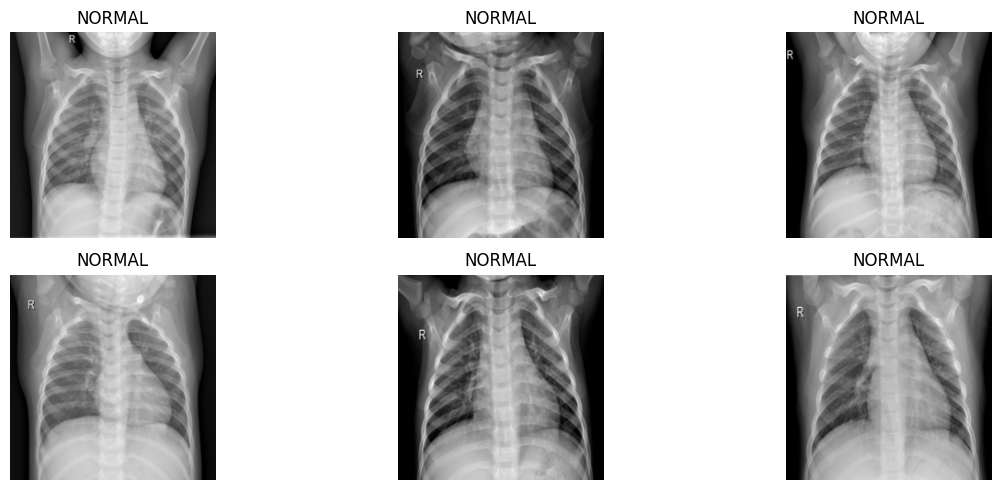

In [ ]:
from collections import defaultdict

print("Detected Categories:", train_data.classes)

label_counts = defaultdict(int)
for _, class_id in train_data:
    label_counts[class_id] += 1
print("Samples per Category in Training Set:", dict(label_counts))

def visualize_samples(dataset, count=6):
    plt.figure(figsize=(13, 5))
    for idx in range(count):
        image, category = dataset[idx]
        image = image.permute(1, 2, 0)
        image = image * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])
        image = torch.clamp(image, 0, 1)
        plt.subplot(2, 3, idx + 1)
        plt.imshow(image)
        plt.title(dataset.classes[category])
        plt.axis("off")
    plt.tight_layout()
    plt.show()

visualize_samples(train_data)


#**Visualizing Class Distribution in the Training Dataset**
This code generates a pie chart showing the percentage distribution of classes in the training dataset, helping to identify class imbalance.

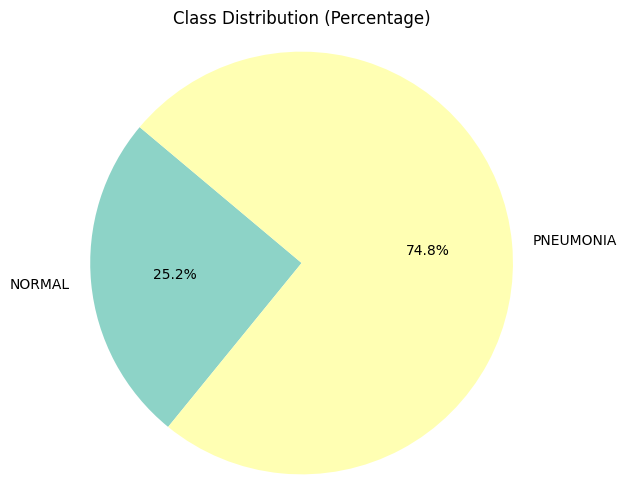

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter

# Get all labels from the dataset
labels = [label for _, label in train_dataset]

# Count each class
class_counts = Counter(labels)

# Get class names using indices
class_names = [train_dataset.classes[i] for i in class_counts.keys()]
class_values = list(class_counts.values())

# Calculate percentages
total = sum(class_values)
percentages = [count / total * 100 for count in class_values]

# Plot as a pie chart
plt.figure(figsize=(6, 6))
plt.pie(percentages, labels=class_names, autopct='%1.1f%%', startangle=140, colors=plt.cm.Set3.colors)
plt.title("Class Distribution (Percentage)")
plt.axis('equal')  # Equal aspect ratio ensures the pie is circular.
plt.show()


#**Load and Customize Pretrained ResNet-18 Model**
Here we load a pretrained ResNet-18 model, freeze all its layers to prevent updates during training, and replace the final fully connected layer to suit binary classification tasks.











In [ ]:
from torchvision import models
import torch.nn as nn

resnet18 = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

for param in resnet18.parameters():
    param.requires_grad = False

resnet18.fc = nn.Linear(resnet18.fc.in_features, 1)


#**Training Function with MLflow**
In this function, I trained a PyTorch model while tracking important parameters and metrics using MLflow. I logged the optimizer type, learning rate, and total number of epochs, and then tracked the training and validation loss and accuracy at each epoch. Finally, I saved the trained model using mlflow.pytorch.log_model() for future use or evaluation.

In [ ]:
import mlflow
import mlflow.pytorch

def run_training(net, train_data, val_data, loss_fn, opt, epochs):
    with mlflow.start_run():
        mlflow.log_param("total_epochs", epochs)
        mlflow.log_param("optimizer_type", opt.__class__.__name__)
        mlflow.log_param("learning_rate", opt.param_groups[0]['lr'])

        for ep in range(epochs):
            net.train()
            total_loss = 0
            correct_preds = 0

            for x_batch, y_batch in train_data:
                opt.zero_grad()
                y_batch = y_batch.float().unsqueeze(1)
                out = net(x_batch)
                prediction = (torch.sigmoid(out) > 0.5)
                loss = loss_fn(out, y_batch)
                loss.backward()
                opt.step()

                total_loss += loss.item() * x_batch.size(0)
                correct_preds += (prediction == y_batch).sum()

            avg_loss = total_loss / len(train_data.dataset)
            train_accuracy = correct_preds.double() / len(train_data.dataset)

            net.eval()
            val_total_loss = 0
            val_correct = 0
            with torch.no_grad():
                for x_val, y_val in val_data:
                    y_val = y_val.float().unsqueeze(1)
                    val_out = net(x_val)
                    val_pred = (torch.sigmoid(val_out) > 0.5)
                    v_loss = loss_fn(val_out, y_val)

                    val_total_loss += v_loss.item() * x_val.size(0)
                    val_correct += (val_pred == y_val).sum()

            avg_val_loss = val_total_loss / len(val_data.dataset)
            val_accuracy = val_correct.double() / len(val_data.dataset)

            mlflow.log_metric("training_loss", avg_loss, step=ep)
            mlflow.log_metric("training_accuracy", train_accuracy.item(), step=ep)
            mlflow.log_metric("validation_loss", avg_val_loss, step=ep)
            mlflow.log_metric("validation_accuracy", val_accuracy.item(), step=ep)

            print(f"Epoch {ep+1}/{epochs} | "
                  f"Train Loss: {avg_loss:.4f} | Train Acc: {train_accuracy:.4f} | "
                  f"Val Loss: {avg_val_loss:.4f} | Val Acc: {val_accuracy:.4f}")

        mlflow.pytorch.log_model(net, "saved_model")


In [ ]:
loss_function = nn.BCEWithLogitsLoss()
optim_algo = optim.Adam(resnet18.fc.parameters(), lr=0.01)
run_training(resnet18, train_batch, val_batch, loss_function, optim_algo, epochs=3)



Epoch 1/3 | Train Loss: 0.2657 | Train Acc: 0.8929 | Val Loss: 0.2450 | Val Acc: 0.9138
Epoch 2/3 | Train Loss: 0.1406 | Train Acc: 0.9433 | Val Loss: 0.1770 | Val Acc: 0.9397
Epoch 3/3 | Train Loss: 0.1608 | Train Acc: 0.9394 | Val Loss: 0.1971 | Val Acc: 0.9397


2025/06/08 16:20:31 WARNING mlflow.utils.requirements_utils: Found torch version (2.6.0+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.6.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/06/08 16:20:54 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.21.0+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torchvision==0.21.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/06/08 16:20:54 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


#**Test Evaluation**
I evaluated my fine-tuned ResNet18 on the test set, calculated accuracy and F1 score using torchmetrics, and logged both metrics with MLflow for tracking.

In [ ]:
with mlflow.start_run():
    resnet18.eval()

    acc = Accuracy(task="binary")
    f1 = F1Score(task="binary")

    preds_list = []
    labels_list = []

    with torch.inference_mode():
        for x, y in test_batch:
            out = resnet18(x)
            pred = torch.sigmoid(out).round()
            preds_list.extend(pred.cpu().tolist())
            labels_list.extend(y.view(-1, 1).cpu().tolist())

    preds_tensor = torch.tensor(preds_list)
    labels_tensor = torch.tensor(labels_list)

    acc_score = acc(preds_tensor, labels_tensor).item()
    f1_score_val = f1(preds_tensor, labels_tensor).item()

    print(f"\nAccuracy on test set: {acc_score:.3f}")
    print(f"F1 Score on test set: {f1_score_val:.3f}")

    mlflow.log_metric("accuracy_test", acc_score)
    mlflow.log_metric("f1score_test", f1_score_val)



Accuracy on test set: 0.838
F1 Score on test set: 0.883


#**MLflow Setup**
This code sets up MLflow in Colab by storing logs locally and exposing the MLflow UI through a public ngrok link, so you can track your model training visually.

In [ ]:
!ngrok config add-authtoken 2xq7aNLP2sqnwkDMvHM1Hmtp57m_39Z5T4eF3ZET9dG7os4Qt

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [ ]:
import os
from pyngrok import ngrok

mlflow_folder = "/content/mlruns"
os.environ["MLFLOW_TRACKING_URI"] = "file://" + mlflow_folder
mlflow.set_tracking_uri("file://" + mlflow_folder)

mlflow_port = 5000
public_url = ngrok.connect(mlflow_port)
print(f"MLflow UI: {public_url}")

get_ipython().system_raw(
    f"mlflow ui --backend-store-uri {mlflow_folder} --port {mlflow_port} &"
)


MLflow UI: NgrokTunnel: "https://8b22-34-59-11-104.ngrok-free.app" -> "http://localhost:5000"


In [ ]:
import torch
torch.save(resnet18.state_dict(), "pneumonia.pth")
torch.save(resnet18, "pneumonia_model.pt")